In [5]:
import pandas as pd
import yfinance as yf

class DataLoader:
    def __init__(self, ticker="AMD", years=4):
        self.ticker = ticker
        self.years = years
        self.data = None

    def fetch_data(self):
        start_date = pd.Timestamp.today() - pd.DateOffset(years=self.years)
        df = yf.download(self.ticker, start=start_date.strftime("%Y-%m-%d"))
        df = df[["Close"]].dropna().reset_index()
        df.columns = ["Date", "Close"]
        self.data = df
        return df


In [6]:
import os
import numpy as np
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Sequential, load_model


class GRUPredictor:
    def __init__(self, input_shape=None, model_path=None):
        if model_path and os.path.exists(model_path):
            self.model = load_model(model_path)
        else:
            self.model = Sequential()
            self.model.add(
                GRU(units=50, return_sequences=False, input_shape=input_shape)
            )
            self.model.add(Dense(1))
            self.model.compile(optimizer="adam", loss="mean_squared_error")

    def train(
        self,
        x_train,
        y_train,
        epochs=20,
        batch_size=32,
        return_history=False,
        progress_callback=None,
    ):
        from tensorflow.keras.callbacks import Callback

        class StreamlitProgressCallback(Callback):
            def __init__(self, total_epochs, bar):
                self.total_epochs = total_epochs
                self.bar = bar

            def on_epoch_end(self, epoch, logs=None):
                progress = int((epoch + 1) / self.total_epochs * 100)
                self.bar.progress(
                    progress,
                    text=f"Epoch {epoch+1}/{self.total_epochs} - Loss: {logs['loss']:.4f}",
                )

        callbacks = []
        if progress_callback:
            callbacks.append(StreamlitProgressCallback(epochs, progress_callback))

        history = self.model.fit(
            x_train,
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            callbacks=callbacks,
        )
        return history if return_history else None

    def predict_next_days(self, last_sequence, days=21):
        predictions = []
        current_sequence = last_sequence
        for _ in range(days):
            prediction = self.model.predict(
                current_sequence.reshape(1, -1, 1), verbose=0
            )
            predictions.append(prediction[0, 0])
            current_sequence = np.append(current_sequence[1:], prediction).reshape(
                -1, 1
            )
        return np.array(predictions).reshape(-1, 1)

    def save(self, path="./models/gru_model.keras"):
        self.model.save(path)

In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

class GRUPreprocessor:
    def __init__(self, sequence_length=60):
        self.scaler = MinMaxScaler()
        self.sequence_length = sequence_length

    def transform(self, data):
        scaled = self.scaler.fit_transform(data[["Close"]])
        x, y = [], []
        for i in range(self.sequence_length, len(scaled)):
            x.append(scaled[i - self.sequence_length : i, 0])
            y.append(scaled[i, 0])
        return np.array(x), np.array(y), scaled

    def reshape_input(self, x):
        return x.reshape((x.shape[0], x.shape[1], 1))

    def inverse_transform(self, values):
        return self.scaler.inverse_transform(values)


In [8]:
import logging
from neuralprophet import NeuralProphet


class NeuralProphetPredictor:
    def __init__(self):
        self.model = NeuralProphet()

    def train_predict(self, df, future_days=21):
        df_prophet = df.rename(columns={"Date": "ds", "Close": "y"})
        self.model.fit(df_prophet, freq="B")
        future = self.model.make_future_dataframe(df_prophet, periods=future_days)
        forecast = self.model.predict(future)
        return forecast[["ds", "yhat1"]].tail(future_days)

In [9]:
import matplotlib.pyplot as plt


class Plotter:
    @staticmethod
    def plot_predictions(
        history_dates, history_values, future_dates, gru_preds, prophet_preds
    ):
        plt.figure(figsize=(14, 7))
        plt.plot(history_dates, history_values, label="Historique")
        plt.plot(future_dates, gru_preds, label="GRU", linestyle="--")
        plt.plot(future_dates, prophet_preds, label="NeuralProphet", linestyle=":")
        plt.title("Prévision du cours de l'action AMD")
        plt.xlabel("Date")
        plt.ylabel("Prix")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

[*********************100%***********************]  1 of 1 completed
WARNING - (py.warnings._showwarnmsg) - d:\Personnels\M2 Keyce\ia\scapping\cc_rnn\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - d:\Personnels\M2 Keyce\ia\scapping\cc_rnn\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.123% of the data.
WARNING - (py.warn

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (32) is too small than the required number                     for the learning rate finder (226). The results might not be optimal.
Finding best initial lr: 100%|██████████| 226/226 [00:04<00:00, 55.43it/s]


Training: |          | 0/? [01:33<?, ?it/s, v_num=1, train_loss=0.00874, reg_loss=0.000, MAE=7.490, RMSE=9.430, Loss=0.00866, RegLoss=0.000]


WARNING - (py.warnings._showwarnmsg) - d:\Personnels\M2 Keyce\ia\scapping\cc_rnn\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.123% of the data.
WARNING - (py.warnings._showwarnmsg) - d:\Personnels\M2 Keyce\ia\scapping\cc_rnn\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - d:\Personnels\M2 Keyce\ia\scapping\cc_rnn\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future versio

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.32it/s]


INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


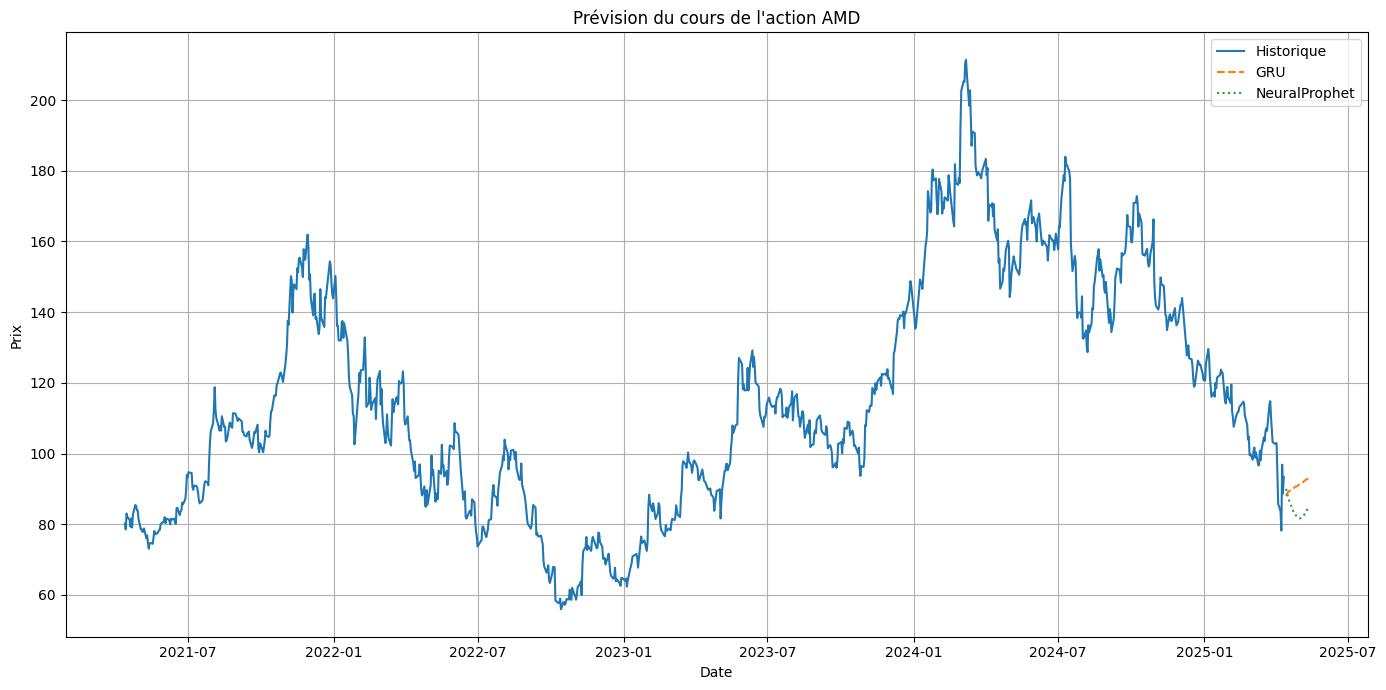

In [11]:
# Load and preprocess data
loader = DataLoader()
df = loader.fetch_data()

pre = GRUPreprocessor()
x, y, scaled = pre.transform(df)
x_reshaped = pre.reshape_input(x)

# GRU
gru_model = GRUPredictor(input_shape=(x_reshaped.shape[1], 1))
gru_model.train(x_reshaped, y)
gru_model.save("../models/gru_model.keras")
last_sequence = x[-1]
predictions_scaled = gru_model.predict_next_days(last_sequence, days=21)
gru_predictions = pre.inverse_transform(predictions_scaled)

# NeuralProphet
prophet_model = NeuralProphetPredictor()
prophet_result = prophet_model.train_predict(df, future_days=21)

# Plot
future_dates = pd.date_range(
    start=df["Date"].iloc[-1] + pd.Timedelta(days=1), periods=21, freq="B"
)
Plotter.plot_predictions(
    history_dates=df["Date"],
    history_values=df["Close"],
    future_dates=future_dates,
    gru_preds=gru_predictions,
    prophet_preds=prophet_result["yhat1"].values,
)